

The dataset used for this **multi-classification problem** is the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet. 


## Preprocessing

We need to pre-process the data so that it can be fed into our convolutional neural network to correctly classify each image as the letter it represents.


In [ ]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [ ]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 244MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 90.8MB/s]


Define some globals with the path to both files you just downloaded:

In [ ]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Here, we do not have the actual images provided, instead we have the data serialized as `csv` files.

We take a look at how the data looks like within the `csv` file:

In [ ]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As we can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values. 

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. 

The original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset
 
Our custom function `parse_data_from_input` below  reads a file passed as input and return 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file.

 A couple of things to keep in mind:
 
- The first line contains the column headers, so you should ignore it.

- Each successive line contains 785 comma-separated values between 0 and 255
  - The first value is the label

  - The rest are the pixel values for that picture

In [ ]:
# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file
  
  Args:
    filename (string): path to the CSV file
    
  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')
    labels = []
    images = []
    for row in list(csv_reader)[1:]:
        label = np.array(row[0], dtype=np.float64)
        labels.append(label)
        image = np.array(np.reshape(row[1:], (28,28)), dtype=np.float64)
        images.append(image)
    return np.array(images), np.array(labels)

In [ ]:
# Test our parse function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


**Expected Output:**
```
Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64
```

## Visualizing the numpy arrays

Now that we have converted the initial csv data into a format that is compatible with computer vision tasks, we will actually see how the images of the dataset look like:

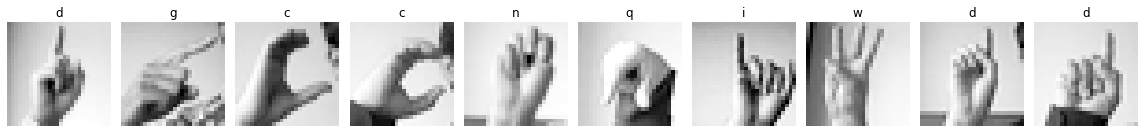

In [ ]:
# Plotting a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Now that we have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, we'll now  code the generators that will yield batches of images, both for training and validation : `train_val_generators` function 

Some important notes:

- The images in this dataset come in the same resolution so we don't need to set a custom `target_size` in this case.
- We need to add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images).

In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    """
    Creates the training and validation data generators
  
    Args:
        training_images (array): parsed images from the train CSV file
        training_labels (array): parsed labels from the train CSV file
        validation_images (array): parsed images from the test CSV file
        validation_labels (array): parsed labels from the test CSV file

    Returns:
        train_generator, validation_generator - tuple containing the generators
  """
    training_images = np.expand_dims(training_images, axis=-1)
    validation_images = np.expand_dims(validation_images, axis=-1)

    # Instantiating the ImageDataGenerator class 
    # Normalizing pixel values 
    # and setting arguments to augment the images 
    train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        height_shift_range=0.2,
                        width_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2)


  # Passing in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
    # Instantiating the ImageDataGenerator class
    # Validation data should not be augmented
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Passing in the appropriate arguments to the flow method
    validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

    return train_generator, validation_generator

In [ ]:
# Testing our generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


**Expected Output:**
```
Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)
```

## Coding the CNN

One last step before training is to define the architecture of the model that will be trained.

We define a custom function  `create_model` that'll should return a Keras model.

Aside from defining the architecture of the model, we also compile it.


In [ ]:
def create_model():

    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
                tf.keras.layers.MaxPooling2D(2,2),

                tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2,2),

                tf.keras.layers.Flatten(),
                
                tf.keras.layers.Dense(1024, activation='relu'),
                # tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(26, activation='softmax')
            ])
  

    model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])       
  
    return model

In [ ]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


858/858 [==============================] - 12s 13ms/step - loss: 1.9496 - accuracy: 0.3941 - val_loss: 0.7050 - val_accuracy: 0.7698
Epoch 2/15
858/858 [==============================] - 11s 12ms/step - loss: 0.8507 - accuracy: 0.7181 - val_loss: 0.2912 - val_accuracy: 0.8936
Epoch 3/15
858/858 [==============================] - 11s 12ms/step - loss: 0.5306 - accuracy: 0.8212 - val_loss: 0.1870 - val_accuracy: 0.9246
Epoch 4/15
858/858 [==============================] - 11s 12ms/step - loss: 0.3843 - accuracy: 0.8714 - val_loss: 0.0896 - val_accuracy: 0.9746
Epoch 5/15
858/858 [==============================] - 11s 12ms/step - loss: 0.2931 - accuracy: 0.9027 - val_loss: 0.0561 - val_accuracy: 0.9826
Epoch 6/15
858/858 [==============================] - 11s 13ms/step - loss: 0.2310 - accuracy: 0.9234 - val_loss: 0.0309 - val_accuracy: 0.9922
Epoch 7/15
858/858 [==============================] - 11s 12ms/step - loss: 0.2003 - accuracy: 0.9332 - val_loss: 0.0663 - val_accuracy: 0.9776
Epo

We now take a look at your training history:

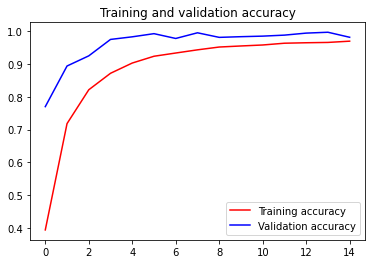

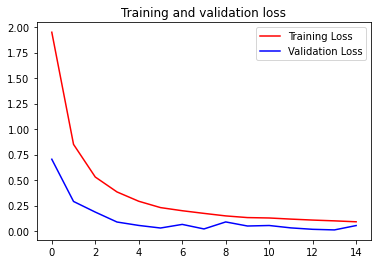

In [ ]:
# Plotting the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### References:
[deepLearning.ai - TF](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/home/welcome)